# Proper Orthogonal Decomposition(POD) (2023/08/17)

参考文献: Chs.11 and 12, Brunton, Steven L., and J. Nathan Kutz. Data-driven science and engineering: Machine learning, dynamical systems, and control. Cambridge University Press, 2022.


$u(x,t)$に関する次の偏微分方程式を考える．
$$
\frac{du}{dt} = Lu+N(u,u_x,u_{xx},\ldots)
$$
ここで，$L$は線形演算子で，$N(u,u_x,u_{xx},\ldots,x,t)$はそれ以外の非線形項に対応する．

$N(\cdot) = 0$で$L$がStrum-Lioville演算子ならば，その固有値問題に還元される．
$$
\frac{du}{dt} = Lu
$$

このとき，与えられる境界条件に対し，$k$番目のモードの固有関数$\psi_k(x)$と，その係数$a_k(t)$を用いて解が構成できる．
$$
u(x,t)=\sum_{k=1}^r a_k(t)\psi_k(x)
$$
これを固有関数展開という．

ここで$x$について$n$点に離散化して，
$$
[U(t)]_i = u(x_i,t),\\
[A(t)]_j = a_j(t),\\
[\Psi]_{ij} = \psi_j(x_i)\\
i = 1,\ldots,n,\quad j = 1,\ldots,r
$$
となるベクトル$U(t),A(t)$と行列$\Psi$とすると，$U=\Psi A$となる．

各モードの固有関数は互いに直交するため$\Psi^T\Psi\approx I$である．これを用いて，偏微分方程式を書き直せば，
$$
\frac{d A(t)}{dt} = \Psi^T L  \Psi A(t) + \Psi^T N(\Psi A(t),\Psi_{x} A(t),\Psi_{xx} A(t),\ldots)
$$
となる．

つまり，$x$に関する$n$点での$u$の連立常方程式から，モード数$r$本の連立方程式へと還元することができる．


## 固有関数展開の例

ここでは，次の2つを見る
1. 主要なモードのみで解を構成することができること
2. 特異値分解(SVD)を用いて数値的に求めたモードが，解析的に決まる固有関数と相似すること

### Schrodinger方程式 (Harmonic Oscillator)

2次関数型のポテンシャルにトラップされた1次元のSchrodinger方程式は，

$u = u(x,t)$: 波動関数, $x$:座標, $t$:時間として，

$$
iu_t+\frac{1}{2}u_{xx}-\frac{x^2}{2}u = 0
$$

境界条件$x\to\pm\infty$で$u\to0$のもと，Gauss Hermite関数を用いた解析解が次式で与えられる．

$$
u(x,t)=\sum_{k=0}^\infty a_k\exp[-i(k+1/2)t]\psi_k(x)
$$

ここで， Hermite多項式$H_k(x)$によって，

$$
\psi_k(x)=(2^k k \sqrt{\pi})^{-1/2}\exp(-x^2/2)H_k(x)
$$
である．
 

ただし初期条件は，
$$
u(0,x) = \exp(-0.2*(x-x_0)^2)
$$
とする． 

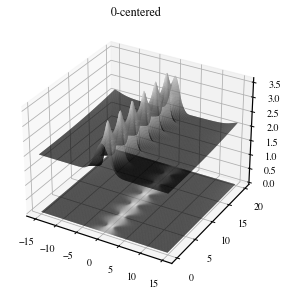

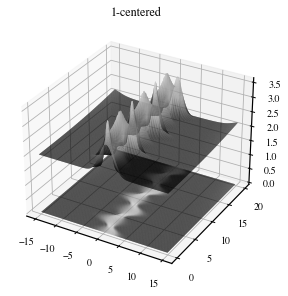

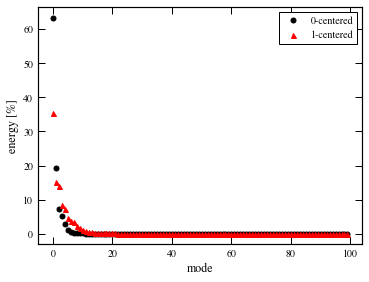

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import hermite
import matplotlib as mpl

## solve the equation and plot the solution

n = 512 # points
L = 30.0 # spatial domain [-L/2, +L/2]
t = np.arange(0.0,20.0,0.2) # time domain correction points
x = np.linspace(-L/2,L/2,n+1)[:n]

def solve(t,x,x0,L,n):
    uk_init = np.fft.fft(np.exp(-0.2*np.power(x-x0,2))) # initial conditions    
    k = n*(2.0*np.pi/L)*np.fft.fftfreq(n)
    V = 0.5*np.power(x,2) # potential
    def rhs_oscillator(t,uk,k=k,V=V,n=n):
        ux = np.fft.ifft(uk)
        return -1.j*0.5*np.power(k,2)*uk - 1.j*np.fft.fft(V*ux) # rhs
    sol = solve_ivp(rhs_oscillator,(t[0],t[-1]),uk_init,t_eval=t)
    usol = np.empty_like(sol.y.T)
    for j in range(len(usol)):
        usol[j] = np.fft.ifft(sol.y[:,j])
    return usol

def plot3d_ns(usol,t,x):
    fig = plt.figure(layout="constrained")
    ax = fig.add_subplot(111, projection='3d')
    light = mpl.colors.LightSource(90, 45)
    illuminated_surface = light.shade(np.abs(usol), cmap=plt.cm.Greys_r)
    X,T = np.meshgrid(x,t)
    cmap = plt.cm.Greys_r
    norm = mpl.colors.Normalize(vmin=np.abs(usol).min(), vmax=np.abs(usol).max())
    colors = cmap(norm(np.abs(usol)))
    ax.plot_surface(X,T,np.abs(usol)+2., 
        rstride=1, cstride=1,linewidth=0,facecolors=illuminated_surface, antialiased=True,vmin=0)
    ax.plot_surface(X,T,np.zeros_like(X), 
        rstride=1, cstride=1,linewidth=0,facecolors=illuminated_surface, antialiased=True,vmin=0)
    return ax

usol0 = solve(t,x,0.0,L,n)
ax = plot3d_ns(usol0,t,x)
ax.set_title("0-centered")
plt.savefig("u0.pdf")

usol1 = solve(t,x,1.0,L,n)
ax = plot3d_ns(usol1,t,x)
ax.set_title("1-centered")
plt.savefig("u1.pdf")
plt.show()

U0,S0,VT0 = np.linalg.svd(usol0.T)
U1,S1,VT1 = np.linalg.svd(usol1.T)
plt.plot(100.0*S0/np.sum(S0),"ko",label="0-centered")
plt.plot(100.0*S1/np.sum(S1),"r^",label="1-centered")
plt.xlabel(r"mode")
plt.ylabel(r"energy [%]")
plt.legend()


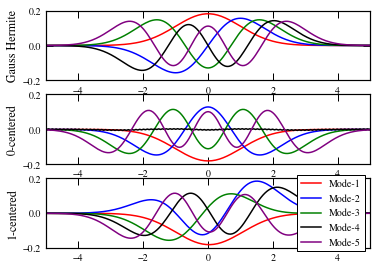

In [4]:
fig,axes = plt.subplots(3,1)
for ax in axes:
    ax.set_xlim(-5.0,5.0)
    ax.set_ylim(-0.2,+0.2)
colors = ["red","blue","green","black","purple"]


for k in range(5):
    phi = (1.0/np.sqrt(np.math.factorial(k)*(2**k)*np.sqrt(np.pi))) * \
            np.exp(-np.power(x,2)*0.5)* hermite(k)(x)
    axes[0].plot(x,phi/np.linalg.norm(phi),color=colors[k])
    axes[1].plot(x,U0.real[:,k],color=colors[k])
    axes[2].plot(x,U1.real[:,k],color=colors[k],label=f"Mode-{k+1}")


axes[0].set_ylabel("Gauss Hermite")
axes[1].set_ylabel("0-centered")
axes[2].set_ylabel("1-centered")
plt.legend(loc="right")
plt.savefig("mode.pdf")

## 次元削減モデルの構築と時間発展

上で求めた基底は，線形演算子$L$で記述される場合に極めて有効である．

一方で，非線形項が存在する場合に有効でないことが予想される．

ここでは，非線形項用にもう一つの基底を構築し，これを用いて時間発展を求める．


### Schrodinger方程式 (Nonlinear)

2次関数型のポテンシャルにトラップされた1次元のSchrodinger方程式は，

$$
iu_t+\frac{1}{2}u_{xx}+|u|^2u = 0
$$

境界条件$x\to\pm\infty$で$u\to0$のもと，初期条件を，
$$
u(0,x) = 2/\cosh(x)
$$
とする． 

### POD + Discrete Empirical Interpolation Method (DEIM)

上式を固有関数展開すると,
$$
\frac{d}{dt}A(t)=\frac{i}{2}\Psi^T\Psi_{xx} A(t) + \Psi^T N(\Psi A) 
$$
となる．ここで，線形演算子$L=(i/2)\Psi^T\Psi_{xx}$は前計算により求めることができる．

また，SVDなどを用いて射非線形項$N(\Psi A)(=i|\Psi A|^2\Psi A)$のモードを求め，次数$p(\sim r)$の低ランク近似，
$$
N \approx \Xi C
$$
なる$\Xi, C$の組を構成できたとしよう． (アルゴリズムは初めに挙げた参考文献を参照)

$n\times p$の射影行列$P$を用いて
$$
\Psi^T N\approx \Psi^T \Xi (P^T\Xi)^{-1}(P^T N)
$$
とすると，$\Psi^T\Xi (P^T\Xi)^{-1}$と$P^T N$は$p\times r$のサイズで表せる．

これによって次数$r\sim p\ll n$に次元削減された線形・非線形のダイナミクスを解くことができる．

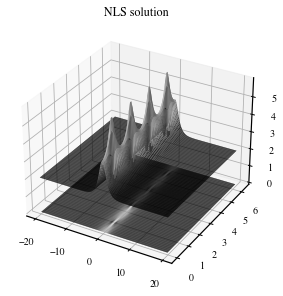

In [29]:

## solve the equation and plot the solution

n = 256 # points
L = 40.0 # spatial domain [-L/2, +L/2]
t = np.linspace(0.0,2*np.pi,61) # time domain correction points
x = np.linspace(-L/2,L/2,n+1)[:n]

def solve(t,x,L,n):
    uk_init = np.fft.fft(2.0/np.cosh(x)) # initial conditions    
    k = n*(2.0*np.pi/L)*np.fft.fftfreq(n)
    def rhs_nonlinear(t,uk,k=k,n=n):
        ux = np.fft.ifft(uk)
        return -1.j*0.5*np.power(k,2)*uk + 1.j*np.fft.fft(np.abs(ux)**2*ux) # rhs
    sol = solve_ivp(rhs_nonlinear,(t[0],t[-1]),uk_init,t_eval=t)
    usol = np.empty_like(sol.y.T)
    for j in range(len(usol)):
        usol[j] = np.fft.ifft(sol.y[:,j])
    return usol

usol = solve(t,x,L,n)
ax = plot3d_nls(usol,t,x)
ax.set_title("NLS solution")
plt.savefig("NLS.pdf")

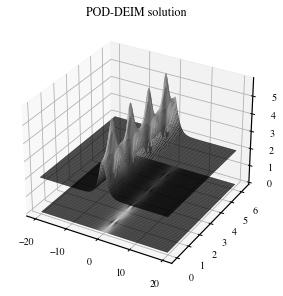

In [30]:
def solve_rom(usol):
    X = usol.T
    U,S,VT = np.linalg.svd(X,full_matrices=False)
    r = 3 # truncated rank
    u0 = 2.0/np.cosh(x)
    Psi = U[:,:r] # POD modes
    a0 = Psi.T @ u0 # initial projected

    NLterm = 1j*np.power(np.abs(X),2)*X
    XI,S_NL,WT = np.linalg.svd(NLterm,full_matrices=0)

    # first DEIM point
    nmax = np.argmax(np.abs(XI[:,0]))
    XI_m = XI[:,0].reshape(n,1)
    z = np.zeros((n,1))
    P = np.copy(z)
    P[nmax] = 1

    # DEIM points 2 to r
    for j in range(1,r):
        c = np.linalg.solve(P.T @ XI_m, P.T @ XI[:,j].reshape(n,1))
        res = XI[:,j].reshape(n,1) - XI_m @ c
        nmax = np.argmax(np.abs(res))
        XI_m = np.concatenate((XI_m,XI[:,j].reshape(n,1)),axis=1)
        P = np.concatenate((P,z),axis=1)
        P[nmax,j] = 1

    P_NL = Psi.T @ (XI_m @ np.linalg.pinv(P.T @ XI_m)) # nonlinear projection
    P_Psi = P.T @ Psi # interpolation of Psi

    ## preprocess for linear term
    Lxx = np.empty((n,r),dtype="complex")
    for j in range(r):
        k = n*(2.0*np.pi/L)*np.fft.fftfreq(n)
        Lxx[:,j] = np.fft.ifft(-np.power(k,2)*np.fft.fft(Psi[:,j]))
    Lop = 0.5 * 1j * Psi.T @ Lxx # projected linear term

    def rom_deim_rhs(t,A,P_NL=P_NL,P_Psi=P_Psi,L=L):
        N = P_Psi @ A
        return Lop @ A + 1j * P_NL @ (np.power(np.abs(N),2)*N)

    sol = solve_ivp(rom_deim_rhs,(t[0],t[-1]),a0,t_eval=t)
    Xtilde = Psi @ sol.y    
    return Xtilde

Xtilde = solve_rom(usol)

ax = plot3d_nls(Xtilde.T,t,x)
ax.set_title("POD-DEIM solution")
plt.savefig("POD-DEIM.pdf")